Use an implementation of Hamiltonian MC (`NUTS`) to infer properties of macro lens and one massive subhalo.

In [67]:
import sys, os
sys.path.append('../')

# Use Theano version of lensing gradient
os.environ["DIFF"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from units import *
from tqdm import *
import pymc3 as pm
from lensing_sim import LensingSim
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Grid size
nx, ny = 36, 36

# 1. Generate lens image

Generate lensing image due to a macro lens (paramaterized as a singular isothermal sphere) and one (NFW) massive subhalo located near the Einstein ring of the macro lens.

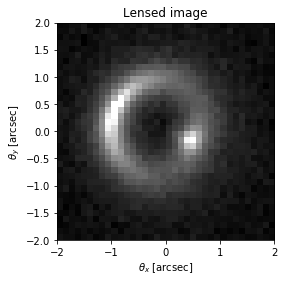

In [66]:
# Host and substructure parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.01, 'theta_y':-0.01, 'theta_E':0.73}
sub_param_dict = {'profile':'nfw', 'theta_x':1.2, 'theta_y':0.5, 'M200':10**12.0*M_s}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

# Observational parameters
observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Generate lensed image
LSI = LensingSim([hst_param_dict, sub_param_dict], [src_param_dict], global_dict, observation_dict)

i_tot = np.random.poisson(LSI.lensed_image().eval())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims)
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');

# 2. Build model in PyMC3 and sample with NUTS

Just simple Poisson regression. Parameters are position of macro lens (`theta_x`, `theta_y`) and its Einstein radius (`theta_E`), proportional to it's size, and subhalo position (`theta_x_sub`, `theta_y_sub`) and log of its mass `logM200`.

In [42]:
# Keep source parameters fixed for now
LSI = LensingSim(sources_list=[src_param_dict], observation_dict=observation_dict, global_dict=global_dict)

In [43]:
# Define PyMC3 model

basic_model = pm.Model()

with basic_model:

    theta_E = pm.Uniform("theta_E", lower=0.1, upper=1.5)
    theta_x = pm.Normal("theta_x", mu=0, sd=0.02)
    theta_y = pm.Normal("theta_y", mu=0, sd=0.02)

    logM200 = pm.Uniform("logM200", lower=5, upper=15)
    theta_x_sub = pm.Normal("theta_x_sub", mu=1, sd=10) # Weak priors
    theta_y_sub = pm.Normal("theta_y_sub", mu=1, sd=10)

    hst_param_dict = {'profile':'sis', 'theta_x':theta_x, 'theta_y':theta_y, 'theta_E':theta_E}
    sub_param_dict = {'profile':'nfw', 'theta_x':theta_x_sub, 'theta_y':theta_y_sub, 'M200':10**logM200*M_s}

    LSI.lenses_list = [hst_param_dict,sub_param_dict]
    Y_obs = pm.Poisson('Y_obs', mu=LSI.lensed_image(), observed=i_tot)

In [44]:
# Sample with NUTS

with basic_model:
    step = pm.NUTS()
    trace = pm.sample(draws=1000, tune=1000, cores=12, chains=12 , step=step)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [theta_y_sub, theta_x_sub, logM200, theta_y, theta_x, theta_E]
Sampling 12 chains: 100%|██████████| 24000/24000 [02:23<00:00, 16.07draws/s]
The acceptance probability does not match the target. It is 0.91587103854218, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9475997665777958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9110170527088065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856182919598302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802185194591292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the targe

# 3. Analyze posteriors

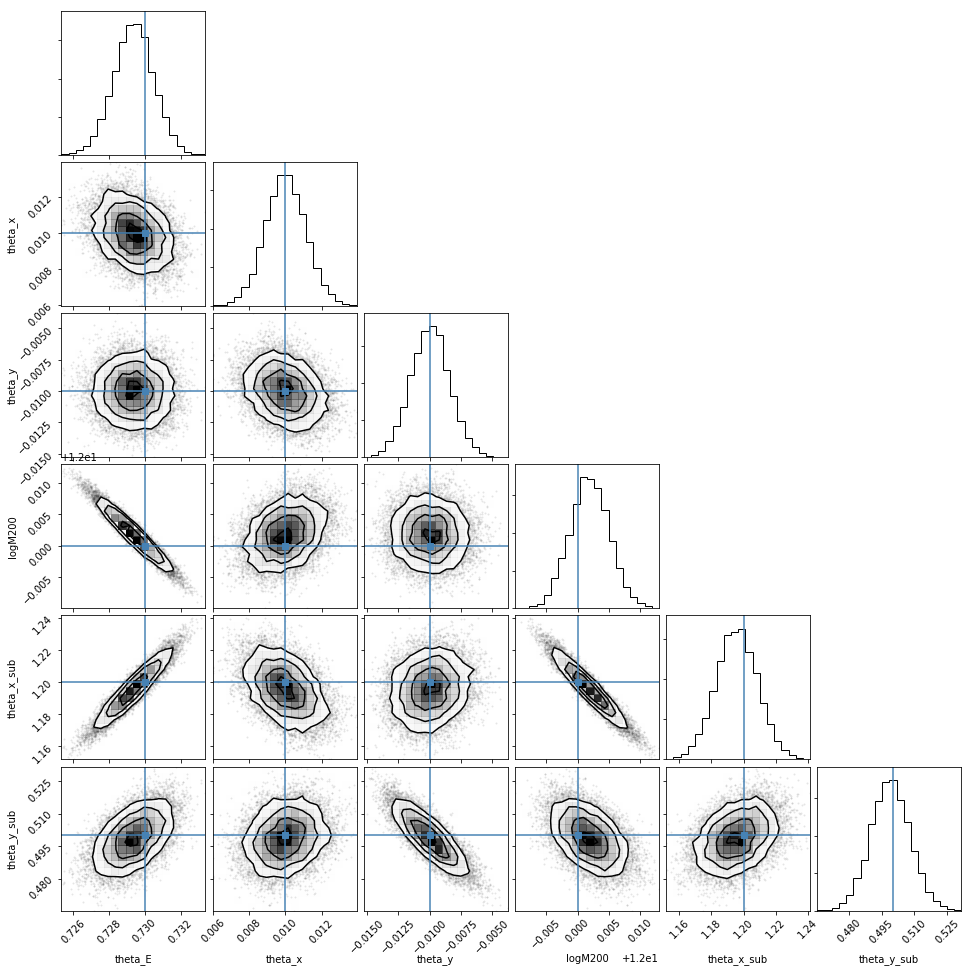

In [53]:
samples = np.vstack([trace[k].flatten() for k in ["theta_E", "theta_x", "theta_y","logM200", "theta_x_sub", "theta_y_sub"]]).T
corner.corner(samples, labels=["theta_E", "theta_x", "theta_y","logM200", "theta_x_sub", "theta_y_sub"], truths=[0.73, 0.01,-0.01,12,1.2,0.5]);

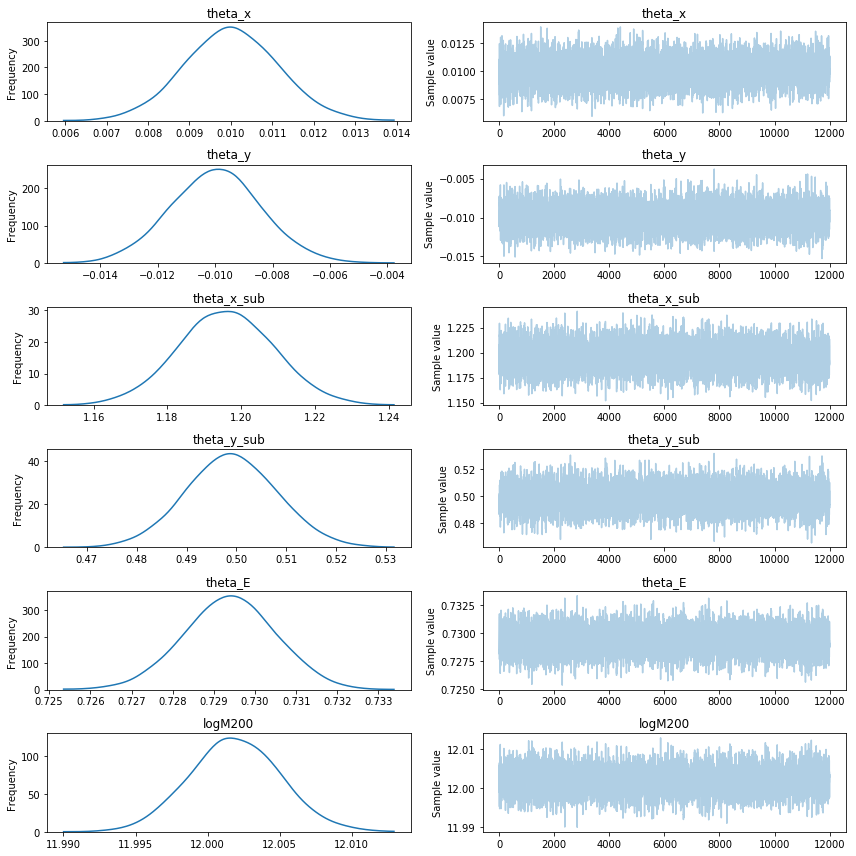

In [45]:
pm.traceplot(trace, combined=True);

In [47]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_x,0.01,0.00,0.0,0.01,0.01,6412.76,1.0
theta_y,-0.01,0.00,0.0,-0.01,-0.01,5616.63,1.0
theta_x_sub,1.20,0.01,0.0,1.17,1.22,3783.25,1.0
theta_y_sub,0.50,0.01,0.0,0.48,0.52,4415.09,1.0
theta_E,0.73,0.00,0.0,0.73,0.73,3649.94,1.0
logM200,12.00,0.00,0.0,12.00,12.01,3653.13,1.0
